<h1>Keras Content Based Image Search Engine wiht AutoEncoders</h1>
<br>
<div>
    <img src="images/0.jpg">
</div>
<br>
<br>
This notebooks provides a guide to how use convolutional autoencoders to develop a Content Based Image Search Engine using Keras and Tensorflow.
<br>
<br>
An Image Search Engine is really similar to text search engines, instead of searching similarities or answers to a text query <i>they are provided images as queries, then they look for similar images.</i>
<br>
<br>
The use of Image Search Engines done with Deep Learning <b>techniques & architectures</b>, can be categorized as a form of <b>unsupervised learning.</b> Some of the reasons why this kind of search engines done with deep learning can be categorized as a form of unsupervised learning, are the next:
<ul>
    <li>During the training of an AutoEncoder, <i>there is not need of using any class labels.</i></li>
    <li>As the AutoEncoder is used to compute the Latent-Space representation for images, this could be interpreted as the 
        <b>feature vector</b> for an image.</li>
    <li>At search time, the distance between the Latent-Space vectors is computed. This distances determines the similarity 
        between images, the smaller the distance, the more visually relevant the images are.</li>
</ul>

This notebook will be divided in the next sections:
<ul>
    <li>How AutoEncoders can be used for Image Search Engines?</li>
    <li>Implementing and Training a Convolutional AutoEncoder.</li>
    <li>Building an Image Search Engine, <i>that uses an AutoEncoder.</i></li>
</ul>

<h2>How AutoEncoders can be used for Image Search Engines?</h2>
<br>
<div>
    <img src="images/1.png">
</div>
<br>
<b>Missing Section: Related To Steps of the Notebook to Explain How AutoEncoders Can Be Used For Image Search Engine.</b>
<br>
<br>
A briefly explanation of how AutoEncoders work is:
<ul>
    <li>Accept an input set of data.</li>
    <li>Internally an <i>AutoEncoder</i> compresses the input data into a <b>Latent-Space</b> representation, <i>this can be 
        understood as a sinlge vector that compresses and quantifies the input</i>.</li>
    <li>The data from the <b>Latent-Space</b> representation is <b><i>reconstructed</i></b> and it is given as output from the 
        output layer.</li>
</ul>
<br>
As we are going to build an image search engine with an AutoEncoder, the most important part is the <b>Latent-Space representation vector</b>, because this distances can give us a notion of similarity between images.
<br>
<br>
When the AutoEncoder has been trained to <i>encode images</i>, we are allow to:
<ul>
    <li>The Encoder Model can be used to compute the <b>Latent-Space</b> representation of each image from the dataset. <i>
        <b>This representation serves as the feature vector that quantifies the contents of an image</b></i> and how similar 
        can be to other images.</li>
    <li>By comparing this <b>feature vector</b> from the queried image to all <b>feature vectors</b> in the dataset, this 
        measurement is usually done with Euclidean or Cosine distance.</li>
</ul>
<br>
Feature vectors that have a <i><b>smaller distance</b></i> will be considered <i><b>more similar</b></i>, while images with a <i><b>larger distance</b></i> will be considered <i><b>less similar</b></i>. After this measurement we can sort the results based on the distance, <i><b>from smallest to largest</b></i> and finally display the image retrievel results to the end user.

<h3>Importing Necessary Libraries, Classes and Packages</h3>

In [1]:
from convautoencoder import ConvAutoEncoder
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import fashion_mnist
from imutils import build_montages
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import pickle

<h2>Implementing and Training a Convolutional AutoEncoder</h2>
<br>
The image below is an example of how a standard architecture of an AutoEncoder is: 
<br>
<br>
<div>
    <img src="images/0.png">
</div>
<h3>Implementing and AutoEncoder</h3>
<br>
The file <code>convautoencoder.py</code> is the class <code>ConvAutoEncoder()</code>, this class has a static method called <code>autoencoder_model()</code>, in this class the architecture for the AutoEncoder that we will implement is defined, I'll provide a quick explanation of how the model is:
<ul>
    <li>The <code>Input</code> is defined for the <code>Encoder</code> as the <code>shape</code> of 
        <code>width, height, depth</code> then we loop through the <code>filters</code> and add set of 
        <code>Conv2D -> LeakyReLU -> BatchNormalization</code> layers, all of this is done from line <b>24 to 36</b>.</li>
    <li>Then the <code>Encoder</code> is flattened and the <b><i>Latent Vector</i></b> is built, this happens from line 
        <b>39 to 41</b>. The <b><i>Latent-Space</i></b> representation is the compressed form of data, once the 
        <code>Encoder</code> is trained, <i>the output of this layer will be the feature vector used to quantify and represent 
        the contents of the input image.</i></li>
    <li>In line <b>44</b> the <code>Decoder</code> starts being built, itwill accept the output of the <code>Encoder</code> 
        model as its inputs, this output it is the <b><i>Latent Space&Vector</i></b>, looping over <code>filters</code> in 
        reverse order the <code>Conv2DTranspose -> LeakyReLU -> BatchNormalization</code> layers are built. The construction of 
        the <code>Decoder</code> starts in line <b>44</b> and it ends in line <b>52</b>.</li>
    <li>The orignal <code>depth</code> of the images must be recovered, this is done from lines <b>55 to 56</b>.</li>
    <li>Finally the <code>AutoEncoder</code> is constructed in line <b>59</b> and returned from the function in line <b>62</b>.
    </li>
</ul>

We have understood how the architecture of the model is, now let's create the AutoEncoder model and plot its architecture.

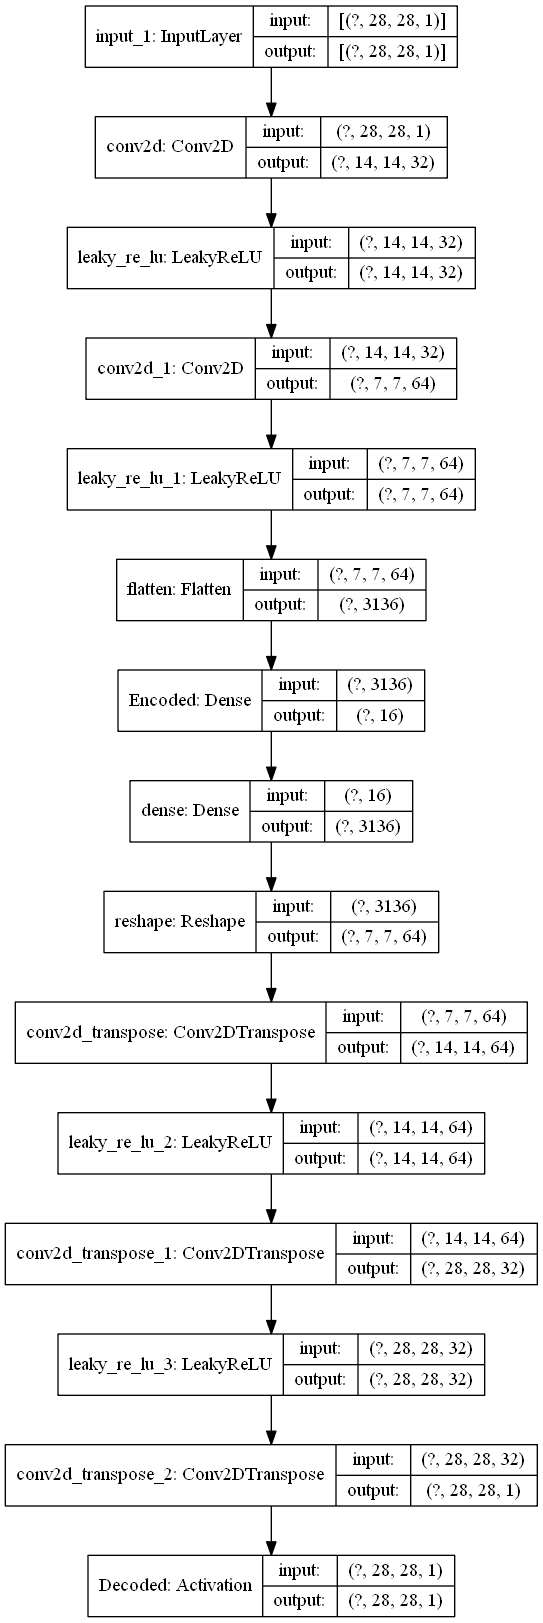

In [2]:
ae_model = ConvAutoEncoder().autoencoder_model(width=28, height=28, depth=1)
plot_model(ae_model, show_shapes=True, show_layer_names=True, dpi=96)

<h3>Training the AutoEncoder Model</h3>
<br>
We have implemented an AutoEncoder, now it is the time to start the training phase, but first let's create some necessary functions, variables and constants for training, predictions and visualizations.

In [3]:
def visualize_predictions(decoded, gt, samples=10):
    # Initialize the list of output images
    outputs = None

    # loop over our number of output samples
    for i in range(0, samples):
        # grab the original image and reconstructed image
        original = (gt[i] * 255).astype("uint8")
        recon = (decoded[i] * 255).astype("uint8")

        # stack the original and reconstructed image side-by-side
        output = np.hstack([original, recon])

        # if the outputs array is empty, initialize it as the current
        # side-by-side image display
        if outputs is None:
            outputs = output

        # otherwise, vertically stack the outputs
        else:
            outputs = np.vstack([outputs, output])

    # return the output images
    return outputs

<h4>Setting Up the Epochs, Initial Learning Rate and Batch Size</h4>

Let's initialize the number of epochs to train for, an initial learning rate and the batch size:

In [4]:
def visualize_losses(x, y_tl, y_vl):

    fig = go.Figure()
    
    fig.add_trace(go.Scatter(x=ae_History.epoch, y=y_tl,
                        mode='lines+markers',
                        name='Train Loss'))
    
    fig.add_trace(go.Scatter(x=ae_History.epoch, y=y_vl,
                        mode='lines+markers',
                        name='Val Loss'))
    
    fig.update_layout(
        title={
            'text': "Training Loss vs Validation Loss",
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        xaxis_title="Epochs",
        yaxis_title="Loss",
    )

    fig.show()

In [16]:
EPOCHS = 16
INIT_LR = 1e-3
BS = 16

<h4>Importing the Dataset</h4>

The dataset that we are going to use for the purposes of this notebook it is the <code>Fashion MNIST</code> dataset, let's imported:

In [17]:
print("Loading Fasion MNIST dataset...")
((X_train, _), (X_test, _)) = fashion_mnist.load_data()

Loading Fasion MNIST dataset...


Take a look at the shapes of the <code>X's</code> sets:

In [18]:
print("X_train shape: {} and X_Test shape: {}".format(X_train.shape, X_test.shape))

X_train shape: (60000, 28, 28) and X_Test shape: (10000, 28, 28)


Take a look at the intensities of the pixels of the <code>X's</code> sets:

In [19]:
print("X_train pixel intensity:\n{}\n\nX_Test pixel intensity:\n{}".format(X_train[0, 0:10, 0:10], X_test[0, 0:10, 0:10]))

X_train pixel intensity:
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0]]

X_Test pixel intensity:
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


<h4>Some Data Preprocessing</h4>

Let's add a channel dimension to every image in the dataset and then scale the pixel intensities to the range [0, 1]

<b>Adding a Channel Dimension</b>

In [20]:
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

Take a look at the shapes of the X's sets:

In [21]:
print("X_train shape: {} and X_Test shape: {}".format(X_train.shape, X_test.shape))

X_train shape: (60000, 28, 28, 1) and X_Test shape: (10000, 28, 28, 1)


<b>Scaling the Pixel Intensities</b>

In [22]:
X_train = X_train.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0

Take a look at the intensities of the pixels of the <code>X's</code> sets:

In [23]:
print("X_train pixel intensity:\n{}\n\nX_Test pixel intensity:\n{}".format(X_train[0, 0:10, 0:10, 0], X_test[0, 0:10, 0:10, 0]))

X_train pixel intensity:
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.00392157]
 [0.        

<h4>Adam as Optimizer</h4>

In [24]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

<h4>Let's Compile the AutoEncoder Model</h4>

In [25]:
ae_model.compile(loss="mse", optimizer=opt)

<h4>Training Time!</h4>

In [ ]:
# train the convolutional autoencoder
ae_History = ae_model.fit(X_train,
                          X_train,
                          validation_data=(X_test, X_test),
                          epochs=EPOCHS,
                          batch_size=BS,
                          use_multiprocessing=True)

Train on 60000 samples, validate on 10000 samples
Epoch 1/16
60000/60000 [==============================] - 15s 254us/sample - loss: 0.0097 - val_loss: 0.0097
Epoch 2/16
60000/60000 [==============================] - 13s 223us/sample - loss: 0.0094 - val_loss: 0.0096
Epoch 3/16
60000/60000 [==============================] - 14s 227us/sample - loss: 0.0092 - val_loss: 0.0094
Epoch 4/16
60000/60000 [==============================] - 13s 225us/sample - loss: 0.0091 - val_loss: 0.0093
Epoch 5/16
60000/60000 [==============================] - 14s 230us/sample - loss: 0.0089 - val_loss: 0.0092
Epoch 6/16
60000/60000 [==============================] - 14s 227us/sample - loss: 0.0088 - val_loss: 0.0092
Epoch 7/16
60000/60000 [==============================] - 13s 223us/sample - loss: 0.0088 - val_loss: 0.0091
Epoch 8/16
60000/60000 [==============================] - 14s 225us/sample - loss: 0.0087 - val_loss: 0.0090
Epoch 9/16
60000/60000 [==============================] - 14s 231us/sample - l

Let's plot the training loss vs the validation loss, this is done thanks to <code>visualize_losses()</code> method

In [ ]:
visualize_losses(x=ae_History.epoch, y_tl=ae_History.history['loss'], y_vl=ae_History.history['val_loss'])

<h4>Predicting the <i>Unknown</i></h4>
<br>
We are going to use the Convolutional AutoEncoder to make predictions on the testing images, construct the visualization and then save it to disk.

In [ ]:
decoded = ae_model.predict(X_test)
visual_predictions = visualize_predictions(decoded, X_test)
cv2.imwrite("output/visual_predictions.png", visual_predictions)

In the method <code>visualizae_predictions()</code> we create an <i>"image collage"</i> with the real images and reconstructed images, let's see how the AutoEncoder model is doing:

In [ ]:
visual_preds_img = mpimg.imread("output/visual_predictions.png")
plt.figure(figsize=(10, 8))
plt.imshow(visual_preds_img)
plt.show()

The AutoEncoder is doing a great job of reconstructing the input images, this means that the <b><i>Latent-Space</i></b> representation vectors are doing a good job compressing, quantifying, and representing the input image; <i><b>having such a representation is a requirement when building an image retrieval system.</b></i>
<br>
<br>
If the feature vectors cannot capture and quantify the contents of the image, then there is no way that the Image Search Engine system will be able to return relevant images.

<b>Saving the AutoEncoder Model</b>
<br>
<br>
Let's serialize the autoencoder model to disk

In [ ]:
ae_model.save("output/ae_model.h5", save_format="h5")

<h2>Building an Image Search Engine, that uses an AutoEncoder</h2>

Now that the AutoEncoder model has been successfully trained, it is the time for us to start building the Image Search Engine, therefore we first have to implement an <i><b>Image Indexer using the trained AutoEncoder Model</b></i>.
<br>
<br>
We are going to index the feature extraction that is the output from the <code>Encoder</code> model, therefore we will generate the <b>index of feature vectors</b>, these feature vectors are meant to quantify the contents of each image.
<br>
<br>
It could be that for improving the query speed of the Image Search Engine we would have to implement special data structures such as <a href="https://fribbels.github.io/vptree/writeup">VP-Trees</a> and Random Projection Trees.

Let's start this section by loading the AutoEncoder Model and displaying the summary of it:

In [ ]:
ae_model = load_model("output/ae_model.h5")
ae_model.summary()

Now let's create the encoder model which consists of <i>just</i> the encoder portion of the AutoEncoder, by using the <code>input</code> of the AutoEncoder we are able to create a <code>Model</code> while only accessing the <code>encoder</code> <i>block</i> of the network, in example the <b>Latent-Space feature vector</b> as the <code>output</code> 

In [ ]:
encoder = Model(inputs=ae_model.input, outputs=ae_model.get_layer("Encoded").output)

Let's compute the <b>feature vectors</b>:

In [ ]:
features = encoder.predict(X_train)

Now we only have to construct a dictionary that maps the index of the Fasion_MNIST training image to its corresponding <b>Latent-Space</b> representation; this dictionary consist of:
<ul>
    <li><code>indexes</code>: Integer indices of each Fashion MNIST image in the dataset.</li>
    <li><code>features</code>: The corresponding feature vector for each image in the dataset.</li>
</ul>

In [ ]:
indexes = list(range(0, X_train.shape[0]))
data = {"indexes": indexes, "features": features}

We then proceed to write the data dictionary to disk

In [ ]:
f = open("output/data_dictionary.pickle", "wb")
f.write(pickle.dumps(data))
f.close()

<h3>Putting All the Pieces Together</h3>

We are going to use <code>build_montages</code> script from <code>imutils</code> package to display the AutoEncoder Image Search Engine results. Let's start this part of this notebook by creating some methods&functions.
<br>
<br>
Let's create a function call <code>euclidean</code> that computes and returns the euclidean distance between two vectors, this distance determines the similarity between two feature vectors, in our case it will determine the similarity between feature vectors <code>a</code> and <code>b</code>.

In [ ]:
def euclidean(a, b):
    return np.linalg.norm(a - b)

<b>What is the <i>Euclidean distance</i>?</b>
<br>
<br>
It is.... and its formula is:
<div>
</div>
<br>
Below we define the searching function, this function it is called <code>perform_search</code> and it is responsible for comparing all feature vectors for similarity and returning the results. <code>perform_search</code> takes as parameters <code>queryFeatures</code> which is a feature vector for the query image, <code>index</code> of all features search through and <code>maxResults</code> wich will be the quantity of results to return.

In [ ]:
def perform_search(queryFeatures, index, maxResults=64):
    # Initialize our list of results
    results = []

    # loop over the index
    for i in range(0, len(index["features"])):
        """
            Compute the euclidean distance between the query features
            and the features for the current image in the index, then
            update the results list with a 2-tuple consisting of the
            computed distance and the index of the image
        """
        d = euclidean(queryFeatures, index["features"][i])
        results.append((d, i))

    # Sort the results and grab the top ones
    results = sorted(results)[:maxResults]

    # Return the list of results
    return results

Let's recall that the <i><b>Euclidean</b></i> distance determines the similarity of feature vectors, thus it tells us how similar an image is to another, intuitively defines the similarity between images in the next manner:
<ul>
    <li>The <i>smaller the distance</i> means the <i>more similar</i> the images are.</li>
    <li>The <i>bigger the distance</i> means the <i>less similar</i> the images are.</li>
</ul>
<br>
Let's load the indexes from the <code>pickle</code> file:

In [ ]:
index = pickle.loads(open("output/data_dictionary.pickle", "rb").read())

<b>Data Processing</b>
<br>
<br>
Usually data processing must be done, at least the query image that we are going to look for similar images, must be processed in the same way we did process the images that we used to train the AutoEncoder model, in our case we have in memory the images that we are going to used, later in this notebook we are going to use real images related to Fashion MNIST, these new images will be processed as we processed the training images.
<br>
<br>
<b>Random Queries</b>
<br>
<br>
Let's randomly sample a set of testing query image indexes, in this case for simplicity we are going to take only 10 random samples.

In [ ]:
queryIdxs = list(range(0, X_test.shape[0]))
queryIdxs = np.random.choice(queryIdxs, size=10)

<b>Time Has Come</b>
<br>
<br>
By looping over the images queries in <code>queryIdxs</code>:
<ul>
    <li>Grab the <code>queryFeatures</code> and perform the search.</li>
    <li>Initialize a list to hold the result <code>images</code>.</li>
    <li>Loop over the results, scaling the image back to the range <i>[0, 255]</i>, creating an RGB representation from the 
        grayscale image for display, and then adding it to our.</li>
    <li>Display the query image in its own OpenCV window.</li>
    <li>Display a <code>montage</code> of search engine results</li>
    <li>When the user presses a key, we repeat the process with a different query image; continue to press 
        a key as you inspect results until all of our query samples have been searched.</-i>
</ul>

In [ ]:
# loop over the testing indexes
for i in queryIdxs:
    """
        Take the features for the current image, find all similar
        images in our dataset, and then initialize our list of resultimages
    """
    queryFeatures = features[i]
    results = perform_search(queryFeatures, index, maxResults=225)
    images = []

    # loop over the results
    for (d, j) in results:
        # grab the result image, convert it back to the range
        # [0, 255], and then update the images list
        image = (X_train[j] * 255).astype("uint8")
        image = np.dstack([image] * 3)
        images.append(image)

    # Display the query image
    query = (X_test[i] * 255).astype("uint8")
    cv2.imshow("Query", query)

    # Build a montage from the results and display it
    montage = build_montages(images, (28, 28), (15, 15))[0]
    cv2.imshow("Results", montage)
    cv2.waitKey(0)

<h2>Tips to Improve AutoEncoder Image Search Engine</h2>
<br>


<ul>
    <li>Our implementation here is an example of a linear search with O(N) complexity, meaning that it will not scale well.
        To improve the speed of the retrieval system, you should use Approximate Nearest Neighbor algorithms and specialized data structures such as VP-Trees, Random Projection trees, etc., which can reduce the computational complexity to O(log N).</li>
</ul>

In [ ]:
!git add .
!git commit -m "Building an Image Search Engine, that uses an AutoEncoder: data_dictionary.pickle"
!git push -u origin master